## 16. 다음에 볼 영화 예측하기

### 16-6. 프로젝트 - Movielens 영화 SBR

 #### Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작

In [1]:
import datetime as dt
import pandas as pd
import tensorflow
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# print(pandas.__version__)
# print(tensorflow.__version__)

In [2]:
# data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
# train_path = data_path / 'ratings.dat'

from pathlib import Path
data_path = Path.joinpath(Path.cwd(),'data')
train_path = Path.joinpath(Path.cwd(),'data','ratings.dat')

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
# data = data.head(200000)
# data = data.tail(100000)
# data

 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다

Rating 정보가 포함되어 있다

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다.

### Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

UserId의 숫자가 약 6040 개, 아이템 숫자는 약 3706 개가 됩니다.

코드 재사용을 편리하게 하기 위해서 'UserId':'SessionId'로 바꿈

In [5]:
data.rename(columns = {'UserId':'SessionId'},inplace=True)

In [6]:
data

,SessionId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [7]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [9]:
session_length.min(), session_length.max()

(20, 2314)

In [10]:
session_length.quantile(0.999)

1343.181000000005

99.9% 세션은 길이가 1344이하입니다. 길이가 2314인 세션을 확인합니다.

In [11]:
long_session = session_length[session_length==2314].index[0]
data[data['SessionId']==long_session]

,SessionId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


초로 표시된 시간은 년월일로 바꿔줍니다.

In [12]:
data['Time']=pd.to_datetime(data['Time'], unit='s')
data

,SessionId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [13]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

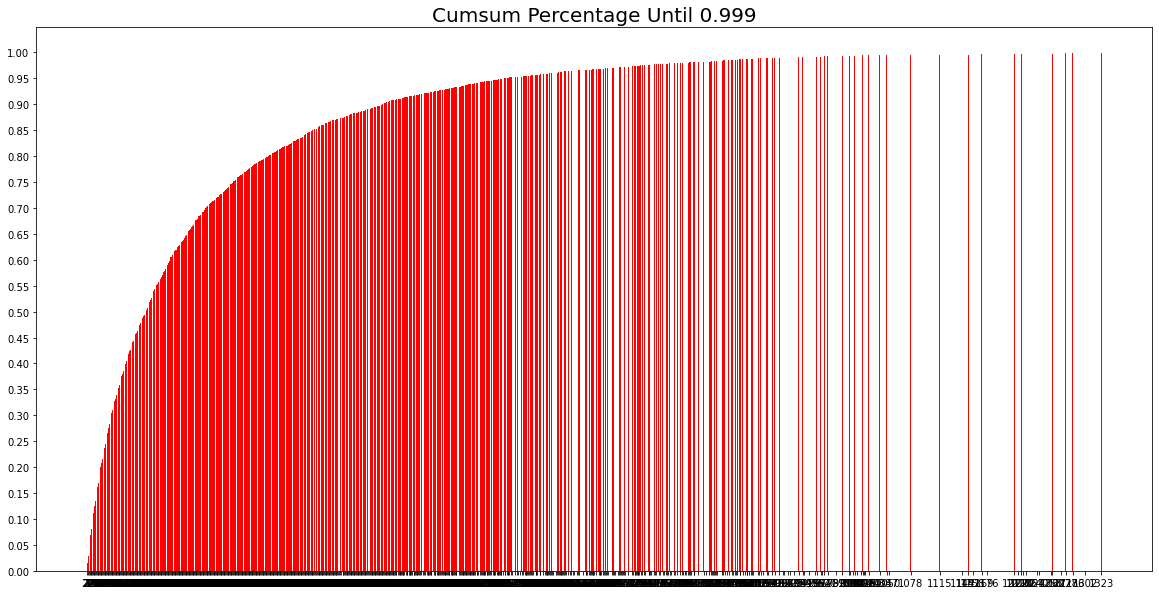

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

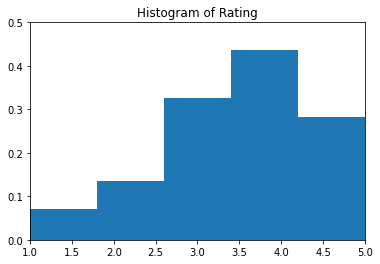

In [15]:
plt.hist(data['Rating'], density=True,bins=5)
plt.title('Histogram of Rating')
plt.axis([1, 5, 0, 0.5])
plt.show()

선호하는 영화를 고르기 위해서 평가점수를 3점 미만으로 낮게 준 데이터는 제거한다.

In [16]:
data = data[data['Rating']>=3]
data

,SessionId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


#### 2.3 Session Time

In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [18]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [19]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

###  3년 동안 900편 이상의 영화에 평점을 남긴 유저는 삭제

In [20]:
def cleanse_long_session(data: pd.DataFrame, longest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len <= longest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

In [21]:
data = cleanse_long_session(data, longest=900) 
data

,SessionId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### 같은시간 한유저가 여러 영화에 평점을 준 데이터는 삭제

In [22]:
data = data.drop_duplicates(subset=['SessionId', 'Time'],keep=False)
data

,SessionId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
9,1,919,4,2000-12-31 22:22:48
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
1000167,6040,161,3,2001-08-10 14:41:26


In [23]:
data.reset_index(drop=True, inplace=True)
data

,SessionId,ItemId,Rating,Time
0,1,3186,4,2000-12-31 22:00:19
1,1,2340,3,2000-12-31 22:01:43
2,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
4,1,919,4,2000-12-31 22:22:48
...,...,...,...,...
212255,6040,3671,4,2001-08-10 14:39:27
212256,6040,232,5,2001-08-10 14:39:58
212257,6040,2917,4,2001-08-10 14:40:29
212258,6040,161,3,2001-08-10 14:41:26


### 3년동안 영화 20편 이하 본 유저 제외  
### 6040명의 유저가 100번도 안본 영화는 제외

In [24]:
data = cleanse_recursive(data, shortest=20, least_click=100) 
data

,SessionId,ItemId,Rating,Time
122,8,1210,4,2000-12-31 02:13:09
123,8,111,5,2000-12-31 02:13:52
124,8,288,5,2000-12-31 02:23:11
125,8,25,5,2000-12-31 02:24:37
127,8,3386,3,2000-12-31 02:32:59
...,...,...,...,...
212253,6040,1673,4,2001-08-10 14:36:52
212254,6040,457,4,2001-08-10 14:39:09
212255,6040,3671,4,2001-08-10 14:39:27
212258,6040,161,3,2001-08-10 14:41:26


In [25]:
SessionId2user_id = {user_id : index for index, user_id in enumerate(data['SessionId'].unique())}

def indexing_SessionId(df, id2idx):
    df['user_id'] = df['SessionId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

data  = indexing_SessionId(data,  SessionId2user_id)
data

,SessionId,ItemId,Rating,Time,user_id
122,8,1210,4,2000-12-31 02:13:09,0
123,8,111,5,2000-12-31 02:13:52,0
124,8,288,5,2000-12-31 02:23:11,0
125,8,25,5,2000-12-31 02:24:37,0
127,8,3386,3,2000-12-31 02:32:59,0
...,...,...,...,...,...
212253,6040,1673,4,2001-08-10 14:36:52,1930
212254,6040,457,4,2001-08-10 14:39:09,1930
212255,6040,3671,4,2001-08-10 14:39:27,1930
212258,6040,161,3,2001-08-10 14:41:26,1930


### 사용하지 않는 평점 데이터 삭제

In [26]:
data = data.loc[:,['SessionId', 'Time', 'ItemId','user_id']]
data

,SessionId,Time,ItemId,user_id
122,8,2000-12-31 02:13:09,1210,0
123,8,2000-12-31 02:13:52,111,0
124,8,2000-12-31 02:23:11,288,0
125,8,2000-12-31 02:24:37,25,0
127,8,2000-12-31 02:32:59,3386,0
...,...,...,...,...
212253,6040,2001-08-10 14:36:52,1673,1930
212254,6040,2001-08-10 14:39:09,457,1930
212255,6040,2001-08-10 14:39:27,3671,1930
212258,6040,2001-08-10 14:41:26,161,1930


#### 2.5 Train / Valid / Test split

In [27]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:47:23'))

## 교재의 방법으로 데이터 셋을 나눔

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [29]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [30]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr,  'train')
stats_info(val, 'valid')
stats_info(test,'test')

* train Set Stats Info
	 Events: 70040
	 Sessions: 1691
	 Items: 492
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-29 23:58:12

* valid Set Stats Info
	 Events: 5971
	 Sessions: 88
	 Items: 492
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 11248
	 Sessions: 152
	 Items: 492
	 First Time : 2000-05-01 11:15:42
	 Last Time : 2003-02-28 17:47:23



### 교재의 방법은 분할 날짜가 원하는대로 되지 않고 있다.   
### 짧은 시간 동안 이루어 지는 인터넷 접속 클릭 데이터를 체크하는 알고리즘을 영화추천에 그대로 적용하는 것은 문제가 있어 보인다.

In [32]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(data['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr   = indexing(tr,  id2idx)
val  = indexing(val, id2idx)
test = indexing(test,id2idx)

In [33]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

#### Data Pipeline

Session-Parallel Mini-Batch 를 구현. 

#### 2.1 SessionDataset

In [34]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets   


In [35]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(50)

,SessionId,Time,ItemId,user_id,item_idx
122,8,2000-12-31 02:13:09,1210,0,0
123,8,2000-12-31 02:13:52,111,0,1
124,8,2000-12-31 02:23:11,288,0,2
125,8,2000-12-31 02:24:37,25,0,3
127,8,2000-12-31 02:32:59,3386,0,4
128,8,2000-12-31 02:34:55,16,0,5
129,8,2000-12-31 02:35:20,2336,0,6
130,8,2000-12-31 02:35:52,2686,0,7
131,8,2000-12-31 02:37:07,3006,0,8
132,8,2000-12-31 02:39:16,1673,0,9


#### 2.2 SessionDataLoader

In [36]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters  = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1           # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]      # data 상에서 session이 시작된 위치를 가져옵니다.
        end   = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask  = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx]   = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [37]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=5)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,user_id,item_idx
122,8,2000-12-31 02:13:09,1210,0,0
123,8,2000-12-31 02:13:52,111,0,1
124,8,2000-12-31 02:23:11,288,0,2
125,8,2000-12-31 02:24:37,25,0,3
127,8,2000-12-31 02:32:59,3386,0,4
128,8,2000-12-31 02:34:55,16,0,5
129,8,2000-12-31 02:35:20,2336,0,6
130,8,2000-12-31 02:35:52,2686,0,7
131,8,2000-12-31 02:37:07,3006,0,8
132,8,2000-12-31 02:39:16,1673,0,9


In [38]:
val_dataset = SessionDataset(val)
val_data_loader = SessionDataLoader(val_dataset, batch_size=5)
val_dataset.df.head(10)

,SessionId,Time,ItemId,user_id,item_idx
4911,157,2000-12-19 17:34:38,858,45,201
4912,157,2000-12-19 17:36:42,3751,45,338
4913,157,2000-12-19 17:41:58,2763,45,457
4915,157,2000-12-19 17:45:13,318,45,30
4916,157,2000-12-19 17:45:57,2289,45,336
4917,157,2000-12-19 17:46:11,265,45,466
4919,157,2000-12-19 17:47:50,150,45,410
4920,157,2000-12-19 17:48:03,1784,45,188
4922,157,2000-12-19 17:49:39,2890,45,264
4923,157,2000-12-19 17:50:06,16,45,5


In [39]:
iter_ex = iter(tr_data_loader)

In [40]:
# inputs, labels, mask =  next(iter_ex)
# print(f'Model Input Item Idx are : {inputs}')
# print(f'Label Item Idx are : {"":5} {labels}')
# print(f'Previous Masked Input Idx are {mask}')

for i in range(10):
    inputs, labels, mask =  next(iter_ex)
    print(f'Model Input Item Idx are : {inputs}')
    print(f'Label Item Idx are : {"":5} {labels}')
    print(f'Previous Masked Input Idx are {mask}')


Model Input Item Idx are : [  0  21  48 112 112]
Label Item Idx are :       [  1   0  49  70 141]
Previous Masked Input Idx are []
Model Input Item Idx are : [  1   0  49  70 141]
Label Item Idx are :       [  2  22  50 113 142]
Previous Masked Input Idx are []
Model Input Item Idx are : [  2  22  50 113 142]
Label Item Idx are :       [  3  23  51  30 122]
Previous Masked Input Idx are []
Model Input Item Idx are : [  3  23  51  30 122]
Label Item Idx are :       [  4  24  52  48 143]
Previous Masked Input Idx are []
Model Input Item Idx are : [  4  24  52  48 143]
Label Item Idx are :       [  5  25  53 114  79]
Previous Masked Input Idx are []
Model Input Item Idx are : [  5  25  53 114  79]
Label Item Idx are :       [  6  26  54 115  57]
Previous Masked Input Idx are []
Model Input Item Idx are : [  6  26  54 115  57]
Label Item Idx are :       [  7  27  21  11 144]
Previous Masked Input Idx are []
Model Input Item Idx are : [  7  27  21  11 144]
Label Item Idx are :       [  8  2

### Step 3. 모델 구성

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.  
이번 자료에서 사용할 모델은 2016년 ICLR에 공개된 SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS 입니다.  
https://arxiv.org/pdf/1511.06939v4.pdf

#### 3.1 Evaluation Metric

Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용

이번 자료에서는 MRR과 Recall@k를 사용

In [41]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### 3.2 Model Architecture

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [43]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [44]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [45]:
# args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.125, lr=0.00125, epochs=50, k=20) # hsz=100은 epochs가 진행해도 개선되는게 없음
args = Args(tr, val, test, batch_size=64, hsz=400, drop_rate=0.1, lr=0.001, epochs=30, k=20) # hsz=400은 정확도는 개선됨

In [46]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 1, 492)]            0         
                                                                 
 GRU (GRU)                   [(64, 400),               1072800   
                              (64, 400)]                         
                                                                 
 dropout (Dropout)           (64, 400)                 0         
                                                                 
 dense (Dense)               (64, 492)                 197292    
                                                                 
Total params: 1,270,092
Trainable params: 1,270,092
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다. 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용

#### 4.1 Model Training

In [47]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            
            
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader  = SessionDataLoader(dataset, batch_size=args.batch_size)

    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [48]:
# # 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.91it/s]


	 - Recall@20 epoch 1: 0.149716
	 - MRR@20    epoch 1: 0.030225



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.96it/s]


	 - Recall@20 epoch 2: 0.192045
	 - MRR@20    epoch 2: 0.044205



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.95it/s]


	 - Recall@20 epoch 3: 0.184659
	 - MRR@20    epoch 3: 0.046263



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.95it/s]


	 - Recall@20 epoch 4: 0.179261
	 - MRR@20    epoch 4: 0.044258



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.94it/s]


	 - Recall@20 epoch 5: 0.173580
	 - MRR@20    epoch 5: 0.042664



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.93it/s]


	 - Recall@20 epoch 6: 0.167045
	 - MRR@20    epoch 6: 0.042370



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.93it/s]


	 - Recall@20 epoch 7: 0.158523
	 - MRR@20    epoch 7: 0.039161



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.94it/s]


	 - Recall@20 epoch 8: 0.154830
	 - MRR@20    epoch 8: 0.037967



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.92it/s]


	 - Recall@20 epoch 9: 0.146023
	 - MRR@20    epoch 9: 0.036446



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.91it/s]


	 - Recall@20 epoch 10: 0.138068
	 - MRR@20    epoch 10: 0.034691



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.91it/s]


	 - Recall@20 epoch 11: 0.135795
	 - MRR@20    epoch 11: 0.031795



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.90it/s]


	 - Recall@20 epoch 12: 0.132386
	 - MRR@20    epoch 12: 0.031153



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.91it/s]


	 - Recall@20 epoch 13: 0.129545
	 - MRR@20    epoch 13: 0.029513



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:29<00:19,  1.88it/s]


	 - Recall@20 epoch 14: 0.119034
	 - MRR@20    epoch 14: 0.029469



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.90it/s]


	 - Recall@20 epoch 15: 0.128409
	 - MRR@20    epoch 15: 0.028268



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.90it/s]


	 - Recall@20 epoch 16: 0.127273
	 - MRR@20    epoch 16: 0.026580



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.90it/s]


	 - Recall@20 epoch 17: 0.116761
	 - MRR@20    epoch 17: 0.024410



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.91it/s]


	 - Recall@20 epoch 18: 0.124148
	 - MRR@20    epoch 18: 0.026760



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.90it/s]


	 - Recall@20 epoch 19: 0.118750
	 - MRR@20    epoch 19: 0.024048



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.91it/s]


	 - Recall@20 epoch 20: 0.121307
	 - MRR@20    epoch 20: 0.024638



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.91it/s]


	 - Recall@20 epoch 21: 0.121875
	 - MRR@20    epoch 21: 0.025280



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:29<00:19,  1.89it/s]


	 - Recall@20 epoch 22: 0.112784
	 - MRR@20    epoch 22: 0.025444



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:29<00:19,  1.87it/s]


	 - Recall@20 epoch 23: 0.114773
	 - MRR@20    epoch 23: 0.025010



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:28<00:18,  1.90it/s]


	 - Recall@20 epoch 24: 0.120170
	 - MRR@20    epoch 24: 0.028785



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:29<00:19,  1.83it/s]


	 - Recall@20 epoch 25: 0.114489
	 - MRR@20    epoch 25: 0.023929



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:30<00:19,  1.82it/s]


	 - Recall@20 epoch 26: 0.117330
	 - MRR@20    epoch 26: 0.024564



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:29<00:19,  1.87it/s]


	 - Recall@20 epoch 27: 0.114205
	 - MRR@20    epoch 27: 0.023295



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:29<00:19,  1.89it/s]


	 - Recall@20 epoch 28: 0.117045
	 - MRR@20    epoch 28: 0.021786



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:29<00:19,  1.87it/s]


	 - Recall@20 epoch 29: 0.116761
	 - MRR@20    epoch 29: 0.024753



Evaluation:  60%|██████████████████████████████████████████▎                           | 55/91 [00:29<00:19,  1.85it/s]

	 - Recall@20 epoch 30: 0.117045
	 - MRR@20    epoch 30: 0.026331



### Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [49]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [50]:
test_model(model, args, test)

Evaluation:  74%|██████████████████████████████████████████████████▎                 | 128/173 [01:09<00:24,  1.84it/s]

	 - Recall@20: 0.106079
	 - MRR@20: 0.023487



#### 학습시 정확도는 올라가나 Recall@k MRR@k 는 조금 올랐다가 더 떨어짐

### 여기서 부터는 데이터를 다른 방법으로 나눠봄

##  5.1 시간을 기준으로 데이터 셋을 나눠봄.

#### 단점: 한유저의 데이터가 시간에 따라 분리 될 수도 있음

In [51]:
def split_by_date1(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date  = data[data['Time'].isin(session_in_test)]
    after_date  = after_date[after_date['ItemId'].isin(before_date['ItemId'])]  # 테스트데이터 아이템이 트레이닝데이터에도 있을 것.
    return before_date, after_date

In [52]:
tr, test = split_by_date1(data, n_days=90)
tr, val  = split_by_date1(tr,   n_days=90)

In [53]:
stats_info(tr,  'train')
stats_info(val, 'valid')
stats_info(test,'test')

* train Set Stats Info
	 Events: 85531
	 Sessions: 1928
	 Items: 492
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 804
	 Sessions: 163
	 Items: 372
	 First Time : 2002-09-01 19:44:55
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 924
	 Sessions: 152
	 Items: 403
	 First Time : 2002-11-30 21:53:04
	 Last Time : 2003-02-28 17:47:23



In [54]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}
tr   = indexing(tr, id2idx)
val  = indexing(val, id2idx)
test = indexing(test, id2idx)

In [55]:
args1_400 = Args(tr, val, test, batch_size=64, hsz=400, drop_rate=0.1, lr=0.001, epochs=30, k=20)

In [56]:
model1_400 = create_model(args1_400)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(64, 1, 492)]            0         
                                                                 
 GRU (GRU)                   [(64, 400),               1072800   
                              (64, 400)]                         
                                                                 
 dropout_1 (Dropout)         (64, 400)                 0         
                                                                 
 dense_1 (Dense)             (64, 492)                 197292    
                                                                 
Total params: 1,270,092
Trainable params: 1,270,092
Non-trainable params: 0
_________________________________________________________________


In [57]:
train_model(model1_400, args1_400)

Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:04,  1.67it/s]


	 - Recall@20 epoch 1: 0.140625
	 - MRR@20    epoch 1: 0.035013



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.96it/s]


	 - Recall@20 epoch 2: 0.156250
	 - MRR@20    epoch 2: 0.061341



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.92it/s]


	 - Recall@20 epoch 3: 0.161458
	 - MRR@20    epoch 3: 0.054698



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.92it/s]


	 - Recall@20 epoch 4: 0.151042
	 - MRR@20    epoch 4: 0.042348



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.93it/s]


	 - Recall@20 epoch 5: 0.140625
	 - MRR@20    epoch 5: 0.039965



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.94it/s]


	 - Recall@20 epoch 6: 0.140625
	 - MRR@20    epoch 6: 0.039578



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.95it/s]


	 - Recall@20 epoch 7: 0.135417
	 - MRR@20    epoch 7: 0.036349



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.76it/s]


	 - Recall@20 epoch 8: 0.130208
	 - MRR@20    epoch 8: 0.030612



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.91it/s]


	 - Recall@20 epoch 9: 0.119792
	 - MRR@20    epoch 9: 0.027894



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.90it/s]


	 - Recall@20 epoch 10: 0.098958
	 - MRR@20    epoch 10: 0.024230



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.89it/s]


	 - Recall@20 epoch 11: 0.119792
	 - MRR@20    epoch 11: 0.020398



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.88it/s]


	 - Recall@20 epoch 12: 0.093750
	 - MRR@20    epoch 12: 0.017842



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.88it/s]


	 - Recall@20 epoch 13: 0.098958
	 - MRR@20    epoch 13: 0.015298



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.90it/s]


	 - Recall@20 epoch 14: 0.104167
	 - MRR@20    epoch 14: 0.018720



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.89it/s]


	 - Recall@20 epoch 15: 0.098958
	 - MRR@20    epoch 15: 0.024294



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.91it/s]


	 - Recall@20 epoch 16: 0.114583
	 - MRR@20    epoch 16: 0.021348



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.87it/s]


	 - Recall@20 epoch 17: 0.104167
	 - MRR@20    epoch 17: 0.011033



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.85it/s]


	 - Recall@20 epoch 18: 0.093750
	 - MRR@20    epoch 18: 0.016116



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:04,  1.57it/s]


	 - Recall@20 epoch 19: 0.104167
	 - MRR@20    epoch 19: 0.017385



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.76it/s]


	 - Recall@20 epoch 20: 0.093750
	 - MRR@20    epoch 20: 0.017657



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.86it/s]


	 - Recall@20 epoch 21: 0.078125
	 - MRR@20    epoch 21: 0.015029



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.85it/s]


	 - Recall@20 epoch 22: 0.093750
	 - MRR@20    epoch 22: 0.010292



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.84it/s]


	 - Recall@20 epoch 23: 0.057292
	 - MRR@20    epoch 23: 0.007518



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.85it/s]


	 - Recall@20 epoch 24: 0.083333
	 - MRR@20    epoch 24: 0.011326



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.82it/s]


	 - Recall@20 epoch 25: 0.062500
	 - MRR@20    epoch 25: 0.014004



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.87it/s]


	 - Recall@20 epoch 26: 0.104167
	 - MRR@20    epoch 26: 0.023255



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.87it/s]


	 - Recall@20 epoch 27: 0.088542
	 - MRR@20    epoch 27: 0.027388



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.89it/s]


	 - Recall@20 epoch 28: 0.104167
	 - MRR@20    epoch 28: 0.022312



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.85it/s]


	 - Recall@20 epoch 29: 0.104167
	 - MRR@20    epoch 29: 0.024804



Evaluation:  30%|█████████████████████▎                                                 | 3/10 [00:01<00:03,  1.82it/s]

	 - Recall@20 epoch 30: 0.067708
	 - MRR@20    epoch 30: 0.014397



In [58]:
test_model(model1_400, args1_400, test)

Evaluation:  33%|███████████████████████▋                                               | 4/12 [00:02<00:04,  1.67it/s]

	 - Recall@20: 0.101562
	 - MRR@20: 0.014591



## 5.2 유저를 기준으로 데이터 셋을 나눠봄  
#### 단점: 유행을 반영하지 못함

In [59]:
def split_by_user(data: pd.DataFrame, val_ratio: float, test_ratio: float):
    n_user = data['SessionId'].nunique()
    
    n_train = int(n_user *(1.0 - (val_ratio + test_ratio)))
    n_val   = int(n_user * val_ratio)
    n_test  = n_user - (n_train + n_val)
    
    train_val_set = data[data['user_id'] <  (n_train+n_val)]
    train_set     = train_val_set[train_val_set['user_id'] <  n_train]
    val_set       = train_val_set[train_val_set['user_id'] >= n_train]
    val_set       = val_set[val_set['ItemId'].isin(train_set['ItemId'])]
    test_set      = data[data['user_id'] >= (n_train+n_val)]
    test_set      = test_set[test_set['ItemId'].isin(train_set['ItemId'])]
    
    return train_set, val_set, test_set

In [60]:
tr, val, test = split_by_user(data, val_ratio=0.1, test_ratio=0.1)

In [61]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 70120
	 Sessions: 1544
	 Items: 492
	 First Time : 2000-07-03 15:25:38
	 Last Time : 2003-02-27 23:31:15

* valid Set Stats Info
	 Events: 8538
	 Sessions: 193
	 Items: 492
	 First Time : 2000-06-01 11:36:01
	 Last Time : 2003-02-28 17:47:23

* test Set Stats Info
	 Events: 8601
	 Sessions: 194
	 Items: 492
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-28 13:12:12



In [62]:
# id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}
tr   = indexing(tr, id2idx)
val  = indexing(val, id2idx)
test = indexing(test, id2idx)

In [63]:
args2_400 = Args(tr, val, test, batch_size=64, hsz=400, drop_rate=0.1, lr=0.001, epochs=30, k=20)

In [64]:
model2_400 = create_model(args2_400)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, 1, 492)]            0         
                                                                 
 GRU (GRU)                   [(64, 400),               1072800   
                              (64, 400)]                         
                                                                 
 dropout_2 (Dropout)         (64, 400)                 0         
                                                                 
 dense_2 (Dense)             (64, 492)                 197292    
                                                                 
Total params: 1,270,092
Trainable params: 1,270,092
Non-trainable params: 0
_________________________________________________________________


In [65]:
train_model(model2_400, args2_400)

Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.89it/s]


	 - Recall@20 epoch 1: 0.140467
	 - MRR@20    epoch 1: 0.031503



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:50<00:15,  1.96it/s]


	 - Recall@20 epoch 2: 0.193971
	 - MRR@20    epoch 2: 0.047624



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:50<00:15,  1.96it/s]


	 - Recall@20 epoch 3: 0.197128
	 - MRR@20    epoch 3: 0.048638



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:50<00:15,  1.97it/s]


	 - Recall@20 epoch 4: 0.192235
	 - MRR@20    epoch 4: 0.048532



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:50<00:15,  1.95it/s]


	 - Recall@20 epoch 5: 0.181029
	 - MRR@20    epoch 5: 0.047657



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:50<00:15,  1.94it/s]


	 - Recall@20 epoch 6: 0.172664
	 - MRR@20    epoch 6: 0.044293



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:51<00:16,  1.91it/s]


	 - Recall@20 epoch 7: 0.166351
	 - MRR@20    epoch 7: 0.041184



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.90it/s]


	 - Recall@20 epoch 8: 0.162247
	 - MRR@20    epoch 8: 0.039894



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.90it/s]


	 - Recall@20 epoch 9: 0.155303
	 - MRR@20    epoch 9: 0.037314



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:53<00:16,  1.86it/s]


	 - Recall@20 epoch 10: 0.147885
	 - MRR@20    epoch 10: 0.033890



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:53<00:16,  1.86it/s]


	 - Recall@20 epoch 11: 0.141730
	 - MRR@20    epoch 11: 0.033130



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:51<00:16,  1.92it/s]


	 - Recall@20 epoch 12: 0.136364
	 - MRR@20    epoch 12: 0.032715



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:51<00:16,  1.91it/s]


	 - Recall@20 epoch 13: 0.134785
	 - MRR@20    epoch 13: 0.030691



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:51<00:16,  1.91it/s]


	 - Recall@20 epoch 14: 0.132891
	 - MRR@20    epoch 14: 0.031209



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.90it/s]


	 - Recall@20 epoch 15: 0.134154
	 - MRR@20    epoch 15: 0.030695



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.89it/s]


	 - Recall@20 epoch 16: 0.129893
	 - MRR@20    epoch 16: 0.030396



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.88it/s]


	 - Recall@20 epoch 17: 0.130682
	 - MRR@20    epoch 17: 0.030319



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.90it/s]


	 - Recall@20 epoch 18: 0.130208
	 - MRR@20    epoch 18: 0.029281



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.90it/s]


	 - Recall@20 epoch 19: 0.129104
	 - MRR@20    epoch 19: 0.030492



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.88it/s]


	 - Recall@20 epoch 20: 0.123422
	 - MRR@20    epoch 20: 0.029678



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:53<00:16,  1.86it/s]


	 - Recall@20 epoch 21: 0.124842
	 - MRR@20    epoch 21: 0.027037



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.90it/s]


	 - Recall@20 epoch 22: 0.122475
	 - MRR@20    epoch 22: 0.027278



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:51<00:16,  1.90it/s]


	 - Recall@20 epoch 23: 0.126420
	 - MRR@20    epoch 23: 0.027254



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.88it/s]


	 - Recall@20 epoch 24: 0.119949
	 - MRR@20    epoch 24: 0.028189



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:58<00:18,  1.69it/s]


	 - Recall@20 epoch 25: 0.121212
	 - MRR@20    epoch 25: 0.027158



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:56<00:17,  1.77it/s]


	 - Recall@20 epoch 26: 0.119476
	 - MRR@20    epoch 26: 0.027250



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:54<00:17,  1.80it/s]


	 - Recall@20 epoch 27: 0.119476
	 - MRR@20    epoch 27: 0.026834



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:53<00:16,  1.85it/s]


	 - Recall@20 epoch 28: 0.116635
	 - MRR@20    epoch 28: 0.025449



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:53<00:16,  1.86it/s]


	 - Recall@20 epoch 29: 0.117109
	 - MRR@20    epoch 29: 0.025405



Evaluation:  76%|████████████████████████████████████████████████████▌                | 99/130 [00:52<00:16,  1.87it/s]

	 - Recall@20 epoch 30: 0.114110
	 - MRR@20    epoch 30: 0.025576



In [66]:
test_model(model2_400, args2_400, test)

Evaluation:  82%|████████████████████████████████████████████████████████            | 108/131 [00:57<00:12,  1.87it/s]

	 - Recall@20: 0.110532
	 - MRR@20: 0.023243



## 후기 :  
#### 직전에 본 영화 데이터로 다음에 볼 영화를 예측하는 방식인데 결과는 신통치 않았다.   
#### 취향을 고려하는 방식이 더 나을 것 같다. 보는 순서보다는 어떤 영화를 여태까지 보았고 다음에 볼 영화는 어떤 범주의 영화 일 것이다 이런식으로 하는 것이 좋아보인다.  
#### epoch가 진행됨에 따라 Recall@20와 MRR@20는 조금 올라가는 듯 싶더니 정확도가 올라갈수록 두 수치는 더 낮아졌다.
#### 트레이닝 셋과 테스트셋의 상관관계를 높이기 위해서 시간과 유저의 제약을 두면 조건에 맞는 데이터량은 줄었다.
#### batch_size=64 를 늘리면 데이터양이 부족해서 그런지 에러가 났다.  
#### hsz=400 100일 경우 평가수치의 개선이 보이지 않았고 400으로 올리자 트레이닝 중 정밀도는 높아졌다. 다른 수치는 그대로거나 조금 높아졌다가 처음보다 더 떨어졌다.

#### 참고
https://github.com/yhs968/pyGRU4REC  
https://github.com/paxcema/KerasGRU4Rec